<a href="https://colab.research.google.com/github/JamesAllingham/DFL-WGAN/blob/master/DFL_WGAN_week4_WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Simple Keras GAN implementation

Below is some boilerplate code for training a GAN to generate pictures of clothing items using Keras. 

The code fetches the FashionMNIST dataset, does a little data-preprocessing, and implements the training loop for the GAN. 

Your job will be to define the generator, discriminator and their loss functions, as well as to play with the various hyper-parameters. 

The goals of this excercise are to:

1. Understand and get comfortable with what GANs are and how we train.

2. Appreciate the difficulties in choosing GAN architectures and hyper-params.

3. Draw some conclusion about the relationship between the GAN loss(es) and the quality of the generated images.

If you aren't familiar with Keras, you [can have a look at the docs](https://keras.io/). You are also more than welcome to use another framework.

###Imports

In [0]:
import tensorflow as tf
import keras # use keras rather than tf.keras to avoid some nasty warning messages during training
# these are some of the layers that might be useful for defining our GAN
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Conv2DTranspose, Conv2D, Input, Activation, UpSampling2D, Dropout, ZeroPadding2D, GlobalAveragePooling2D
from keras.optimizers import Adam, RMSprop
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Load Data

Lets load the FashionMNIST dataset, have a quick look, and do some minor pre-processing:

In [0]:
fashionMNIST = keras.datasets.fashion_mnist
(train_images, train_labels), _ = fashionMNIST.load_data()
fashionMNIST_labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Boot"]

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


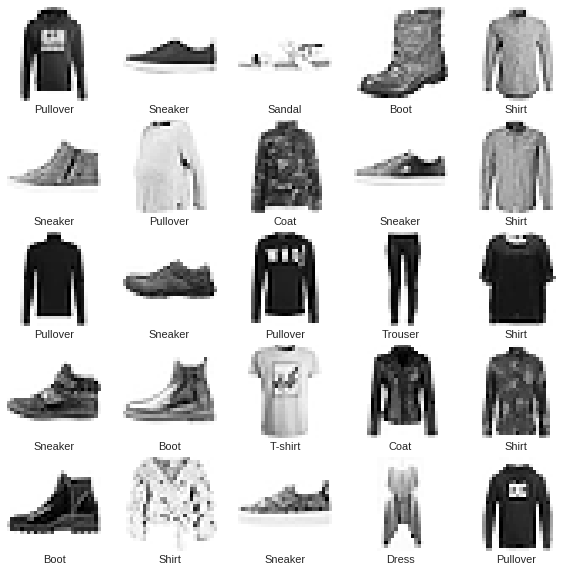

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  img_index = np.random.randint(0, 40000)
  plt.imshow(train_images[img_index])
  plt.xlabel(fashionMNIST_labels[train_labels[img_index]])

In [0]:
# rescale images (seems to help with training - try to remove this next line)
train_images = (train_images.astype(np.float32) - 125.0) / 125.0
# reshape the images so that Keras is happy
train_images = np.expand_dims(train_images, axis=3)

### Define a Discriminator and a Generator

The *discriminator* should take a 28x28x1 array as its input and return a scalar between 0 and 1. This scalar will be interpred as the probability that the image is real.

The *generator* should take a vector and return a 28x28x1 array. The size of the vector is the *latent dimmension* and is a parameter that can be tuned. There is also a choice here: generate images with pixels between 0 and 1, 0 and 255, or even -1 and 1.

The architectures for the generator and discriminator can also be tuned in a number of ways. However, you might want to draw inspiration from the [DCGAN architecture by _Radford et al._](https://arxiv.org/abs/1511.06434). Here are some tips from their [git repo](https://github.com/Newmu/dcgan_code):


* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
* Use batchnorm in both the generator and the discriminator
* Remove fully connected hidden layers for deeper architectures. Just use average pooling at the end. *(For a simple task like FashionMNIST this might not be required.)*
* Use ReLU activation in generator for all layers except for the output, which uses Tanh. *(This means they are generating pixel values between -1 and 1.)*
* Use LeakyReLU activation in the discriminator for all layers.


In [0]:
img_shape = (28, 28, 1)

# define model hyper-params - play with these!
latent_size = 100
alpha = 0.00005 # learning rate

In [0]:
critic = keras.Sequential([
  # your discriminator architecture here
    Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"),
    LeakyReLU(alpha=0.2),
#     Dropout(0.25),
    Conv2D(64, kernel_size=3, strides=2, padding="same"),
    BatchNormalization(momentum=0.8),
    LeakyReLU(alpha=0.2),
#     Dropout(0.25),
    Conv2D(128, kernel_size=3, strides=2, padding="same"),
    BatchNormalization(momentum=0.8),
    LeakyReLU(alpha=0.2),
#     Dropout(0.25),
    Conv2D(256, kernel_size=3, strides=1, padding="same"),
    BatchNormalization(momentum=0.8),
    LeakyReLU(alpha=0.2),
#     Dropout(0.25),
#     Flatten(),
#     Dense(1)
    Conv2D(1, kernel_size=3, strides=1, padding="same"),
    GlobalAveragePooling2D()
    
])

critic.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
batc

In [0]:
generator = keras.Sequential([
  # your generator architecture here
    Dense(7 * 7 * 128, activation="relu", input_dim=latent_size),
    Reshape([7, 7, 128]),
    UpSampling2D(),
    Conv2D(128, kernel_size=3, padding="same"),
    BatchNormalization(momentum=0.8),
    Activation("relu"),
    UpSampling2D(),
    Conv2D(64, kernel_size=3, padding="same"),
    BatchNormalization(momentum=0.8),
    Activation("relu"),
    Conv2D(128, kernel_size=3, padding="same"),
    BatchNormalization(momentum=0.8),
    Activation("relu"),
    Conv2D(1, kernel_size=3, padding="same"),
    Activation("tanh")
])

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 128)       0         
__________

The following code snippit creates a combined model that will allow us to train the generator based on the output of the critic. Note that in the combined model the critic is not trained.

In [0]:
def wgan_loss(y_true, y_pred):
        return K.mean(y_true * y_pred)
  
critic.trainable = False
combined = keras.Sequential([
    generator,
    critic
])

combined.compile(loss=wgan_loss, optimizer=RMSprop(alpha))

combined.summary()

critic.trainable = True
critic.compile(loss=wgan_loss, optimizer=RMSprop(alpha))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 1)         931137    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 391937    
Total params: 1,323,074
Trainable params: 930,497
Non-trainable params: 392,577
_________________________________________________________________


### Train the GAN

Depending on your architectures of your generator and discriminator you might need to train for 1000 to 10000 rounds before you see any reasonable images being generated.

**Hint: Select a GPU or under `Runtime > Change runtime type` to speed up training** 

**Hint: You might want to modify the training loop to periodically save generated images and the corresponding loss(es) so that you can look at them later**

In [0]:
# define training hyper-params
rounds = 30000
batch_size = 64
n_critic = 5
clip_value = 0.01

# create labels
real_labels = -np.ones((batch_size, 1))
gen_labels = np.ones((batch_size, 1))

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 	 C loss: 0.999858 	 G loss: 1.000125 	 n iter: 100


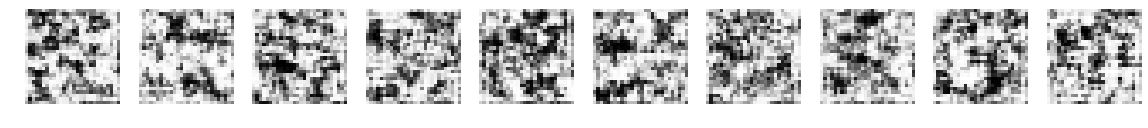

100 	 C loss: 1.001370 	 G loss: 1.005690 	 n iter: 5


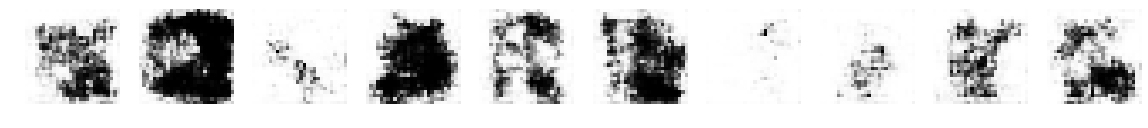

200 	 C loss: 1.001404 	 G loss: 1.002734 	 n iter: 5


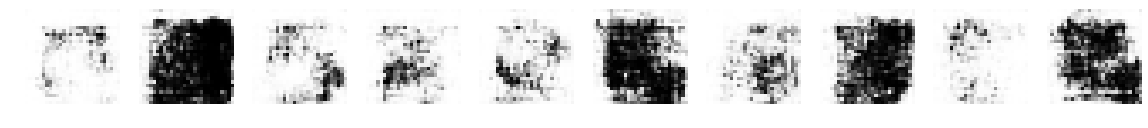

300 	 C loss: 1.000296 	 G loss: 1.001957 	 n iter: 5


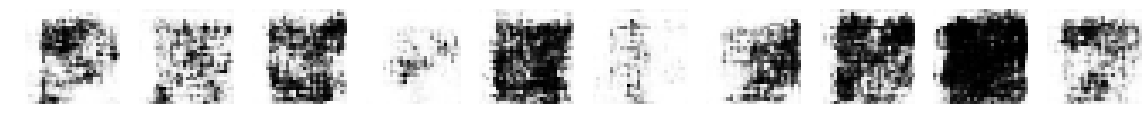

400 	 C loss: 1.000776 	 G loss: 1.002121 	 n iter: 5


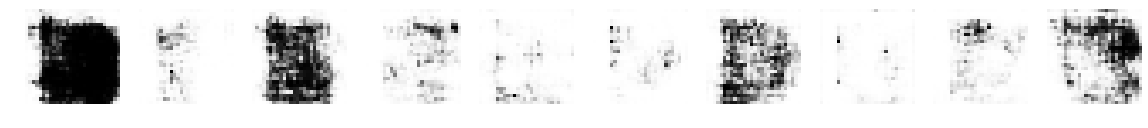

500 	 C loss: 1.002385 	 G loss: 1.002170 	 n iter: 100


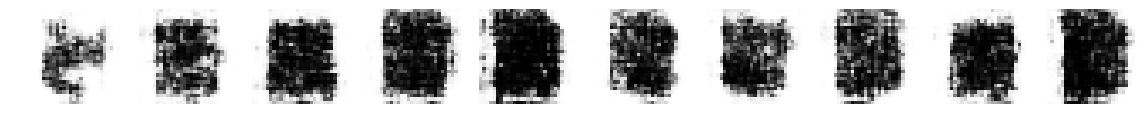

600 	 C loss: 0.999686 	 G loss: 1.003011 	 n iter: 5


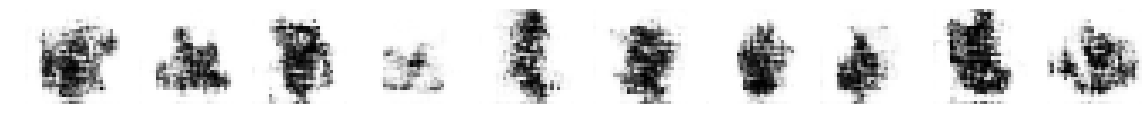

700 	 C loss: 0.999628 	 G loss: 1.002459 	 n iter: 5


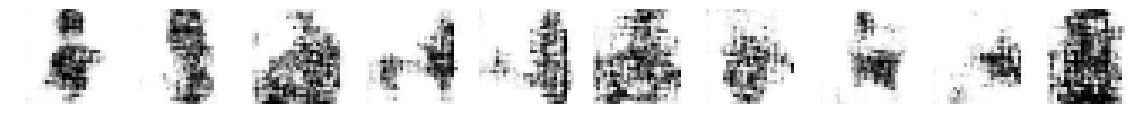

800 	 C loss: 0.999675 	 G loss: 1.001583 	 n iter: 5


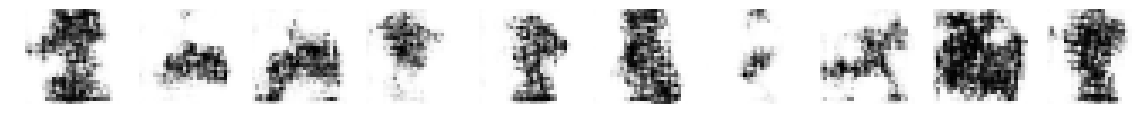

900 	 C loss: 0.999754 	 G loss: 1.001106 	 n iter: 5


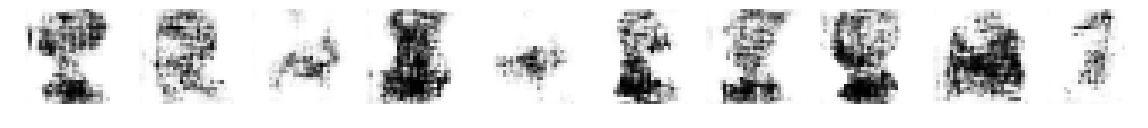

1000 	 C loss: 0.999855 	 G loss: 1.000878 	 n iter: 100


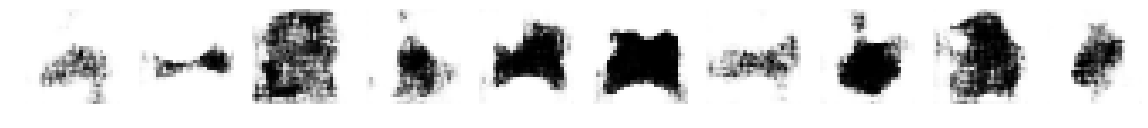

1100 	 C loss: 0.999724 	 G loss: 1.000574 	 n iter: 5


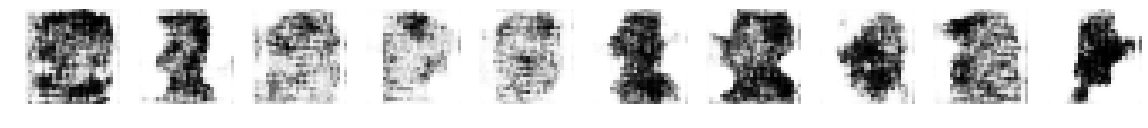

1200 	 C loss: 0.999718 	 G loss: 1.000505 	 n iter: 5


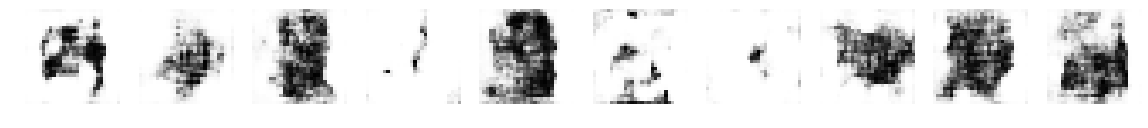

1300 	 C loss: 0.999760 	 G loss: 1.000022 	 n iter: 5


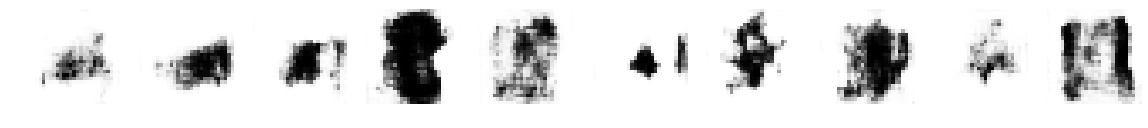

1400 	 C loss: 0.999761 	 G loss: 0.999721 	 n iter: 5


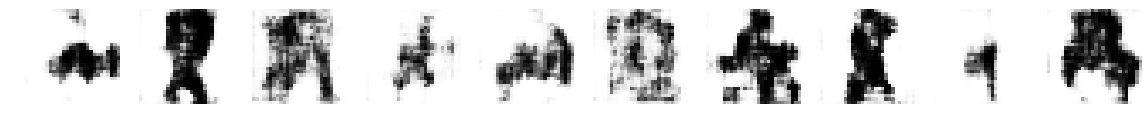

1500 	 C loss: 0.999813 	 G loss: 0.999402 	 n iter: 100


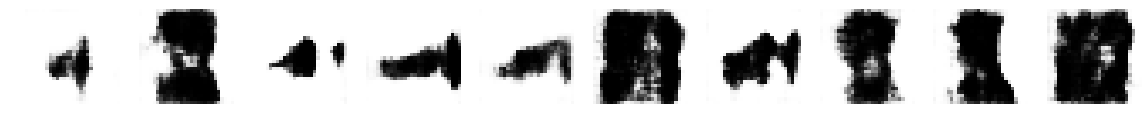

1600 	 C loss: 0.999808 	 G loss: 0.999220 	 n iter: 5


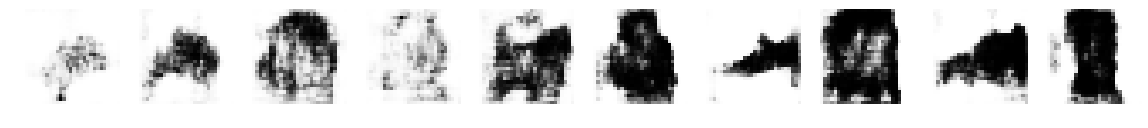

1700 	 C loss: 0.999808 	 G loss: 0.999034 	 n iter: 5


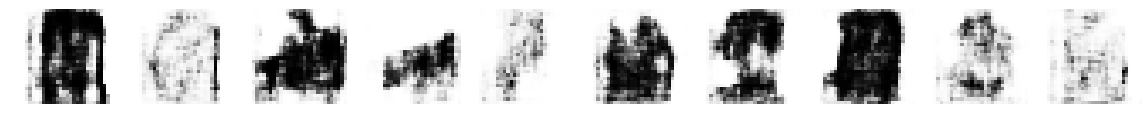

1800 	 C loss: 0.999824 	 G loss: 0.998897 	 n iter: 5


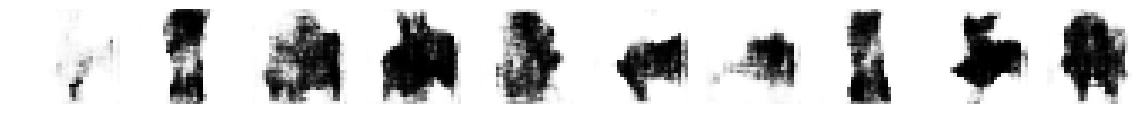

1900 	 C loss: 0.999850 	 G loss: 0.998790 	 n iter: 5


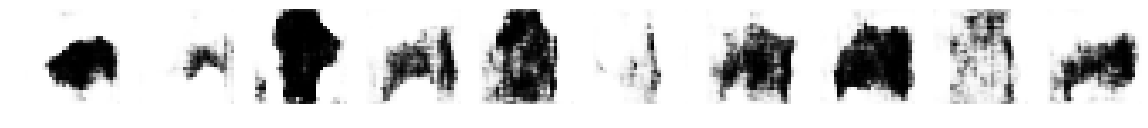

2000 	 C loss: 0.999885 	 G loss: 0.998633 	 n iter: 100


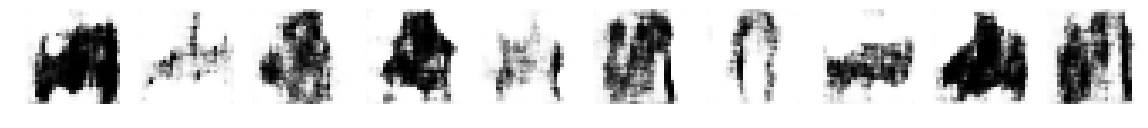

2100 	 C loss: 0.999946 	 G loss: 0.998427 	 n iter: 5


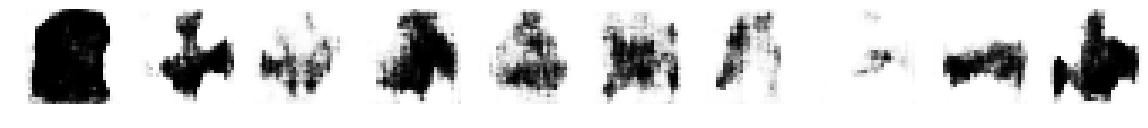

2200 	 C loss: 0.999841 	 G loss: 0.998442 	 n iter: 5


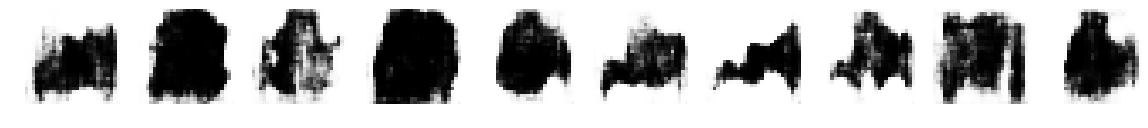

2300 	 C loss: 0.999905 	 G loss: 0.998422 	 n iter: 5


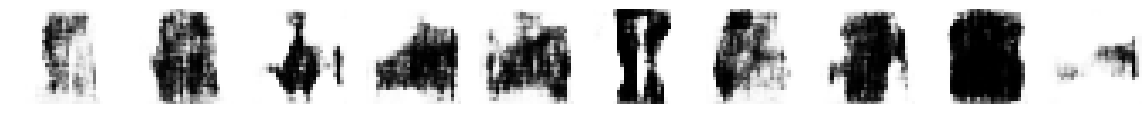

2400 	 C loss: 0.999933 	 G loss: 0.998431 	 n iter: 5


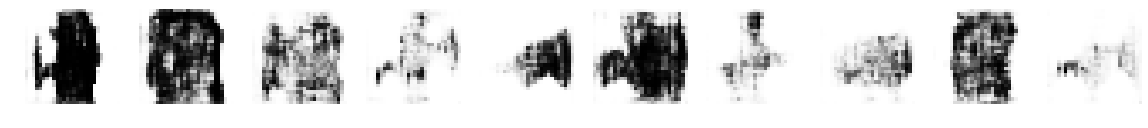

2500 	 C loss: 0.999925 	 G loss: 0.998688 	 n iter: 100


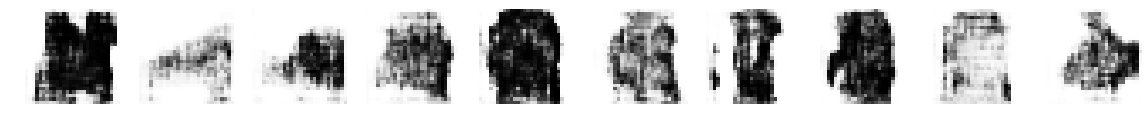

2600 	 C loss: 0.999917 	 G loss: 0.999031 	 n iter: 5


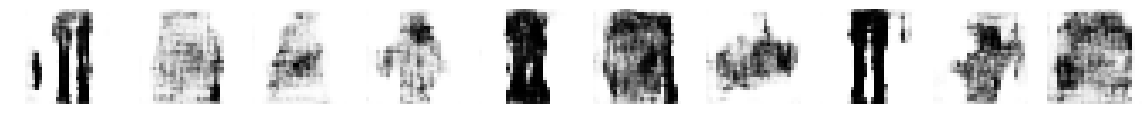

2700 	 C loss: 0.999924 	 G loss: 0.999320 	 n iter: 5


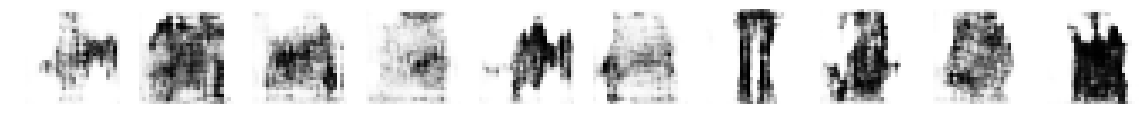

2800 	 C loss: 0.999940 	 G loss: 0.999564 	 n iter: 5


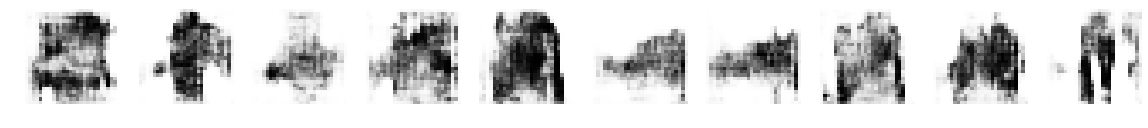

2900 	 C loss: 0.999936 	 G loss: 0.999808 	 n iter: 5


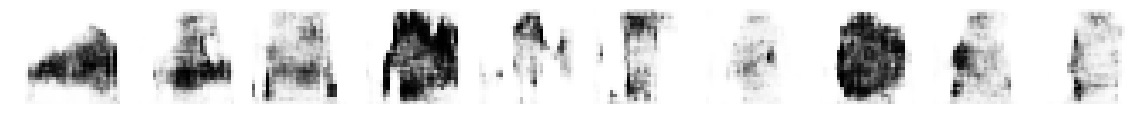

3000 	 C loss: 0.999948 	 G loss: 1.000017 	 n iter: 100


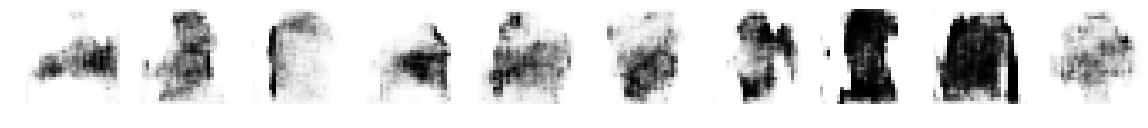

3100 	 C loss: 0.999953 	 G loss: 1.000051 	 n iter: 5


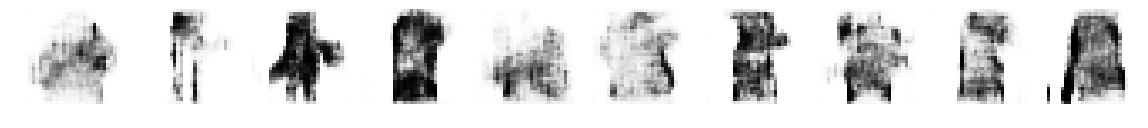

3200 	 C loss: 0.999955 	 G loss: 1.000066 	 n iter: 5


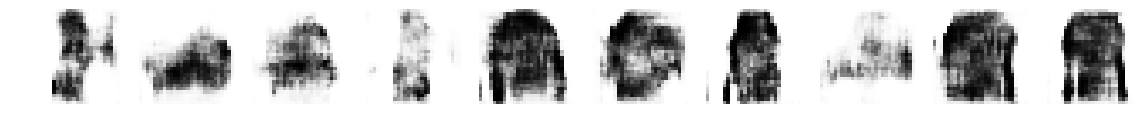

3300 	 C loss: 0.999953 	 G loss: 1.000070 	 n iter: 5


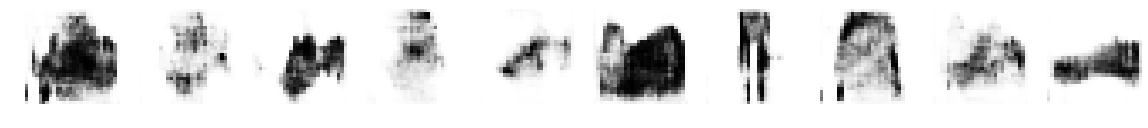

3400 	 C loss: 0.999960 	 G loss: 1.000069 	 n iter: 5


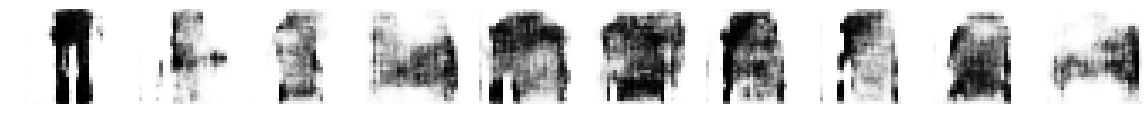

3500 	 C loss: 0.999959 	 G loss: 1.000072 	 n iter: 100


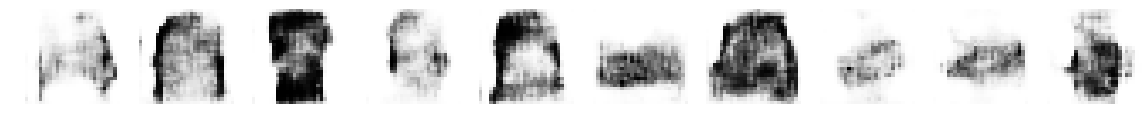

3600 	 C loss: 0.999960 	 G loss: 1.000073 	 n iter: 5


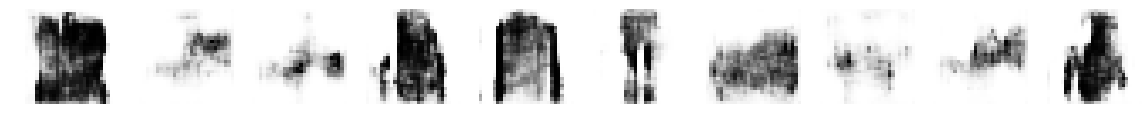

3700 	 C loss: 0.999959 	 G loss: 1.000074 	 n iter: 5


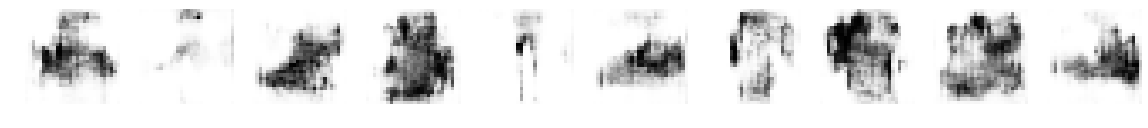

3800 	 C loss: 0.999959 	 G loss: 1.000077 	 n iter: 5


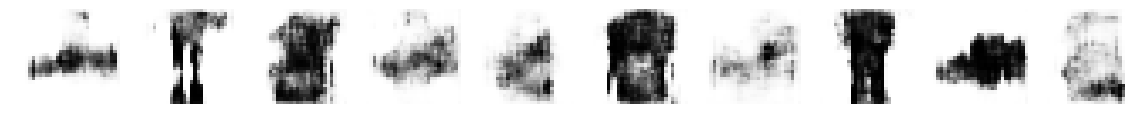

3900 	 C loss: 0.999955 	 G loss: 1.000077 	 n iter: 5


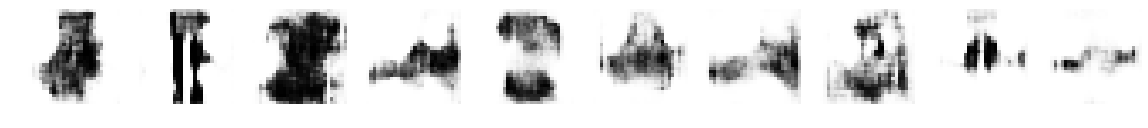

4000 	 C loss: 0.999958 	 G loss: 1.000074 	 n iter: 100


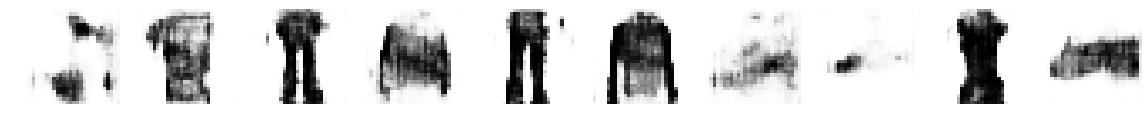

4100 	 C loss: 0.999961 	 G loss: 1.000080 	 n iter: 5


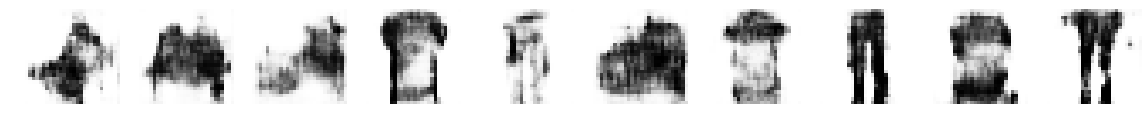

4200 	 C loss: 0.999955 	 G loss: 1.000079 	 n iter: 5


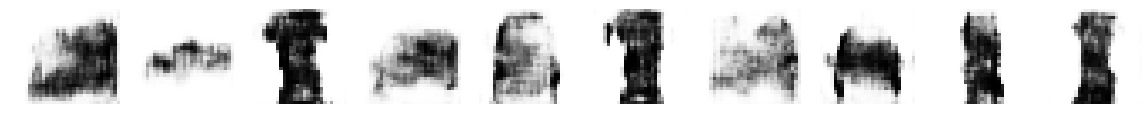

4300 	 C loss: 0.999951 	 G loss: 1.000080 	 n iter: 5


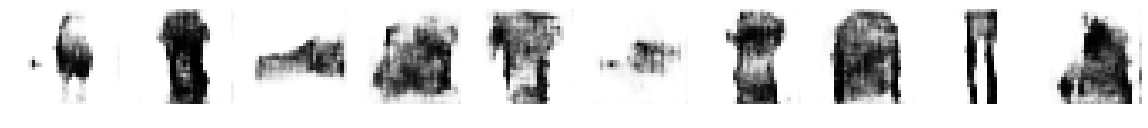

4400 	 C loss: 0.999957 	 G loss: 1.000081 	 n iter: 5


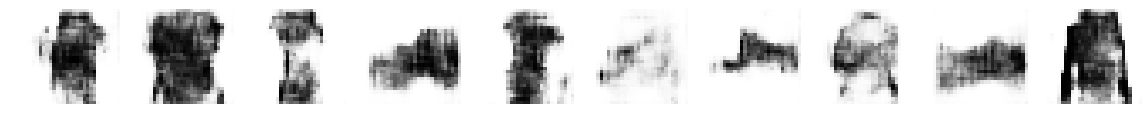

4500 	 C loss: 0.999955 	 G loss: 1.000077 	 n iter: 100


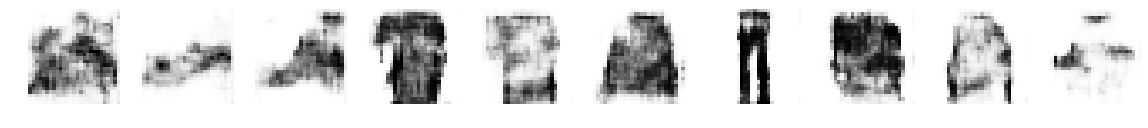

4600 	 C loss: 0.999955 	 G loss: 1.000074 	 n iter: 5


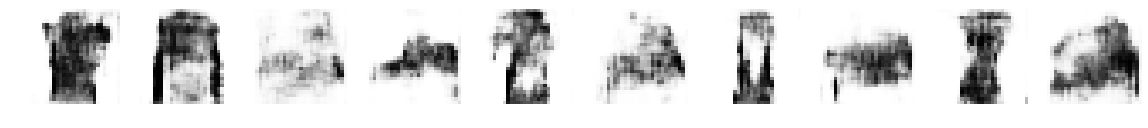

4700 	 C loss: 0.999956 	 G loss: 1.000069 	 n iter: 5


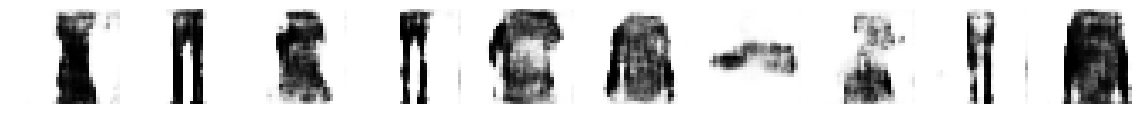

4800 	 C loss: 0.999951 	 G loss: 1.000076 	 n iter: 5


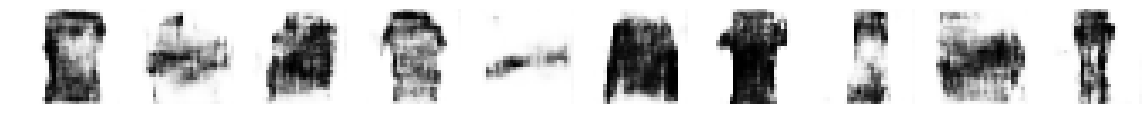

4900 	 C loss: 0.999953 	 G loss: 1.000075 	 n iter: 5


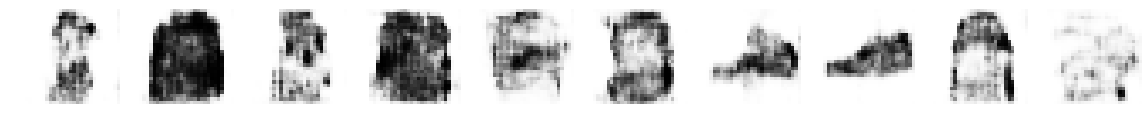

5000 	 C loss: 0.999952 	 G loss: 1.000069 	 n iter: 100


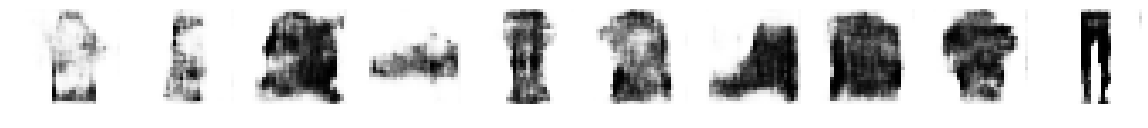

5100 	 C loss: 0.999952 	 G loss: 1.000076 	 n iter: 5


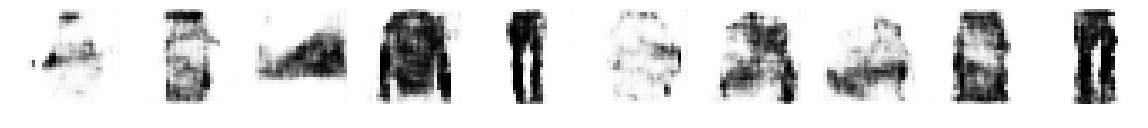

5200 	 C loss: 0.999951 	 G loss: 1.000072 	 n iter: 5


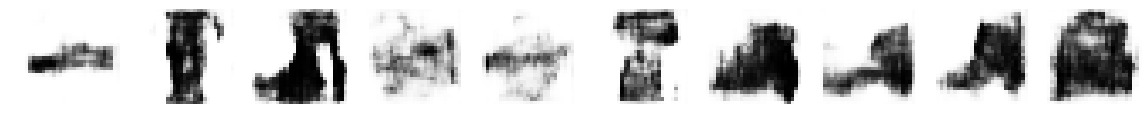

5300 	 C loss: 0.999954 	 G loss: 1.000070 	 n iter: 5


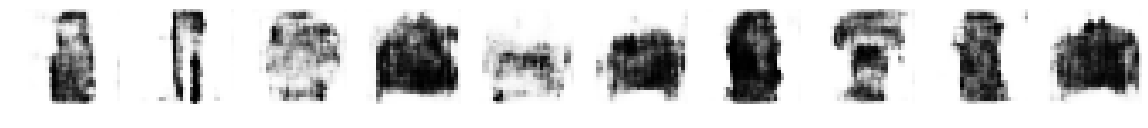

5400 	 C loss: 0.999949 	 G loss: 1.000073 	 n iter: 5


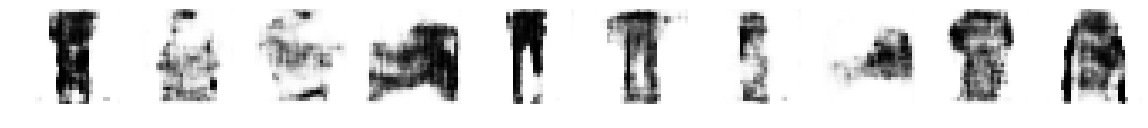

5500 	 C loss: 0.999948 	 G loss: 1.000070 	 n iter: 100


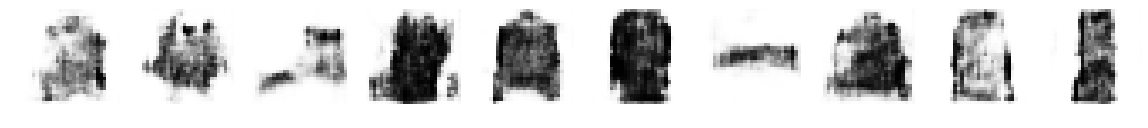

5600 	 C loss: 0.999953 	 G loss: 1.000070 	 n iter: 5


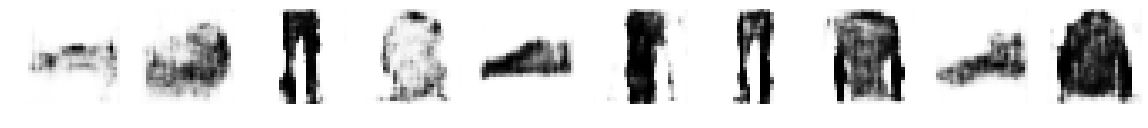

5700 	 C loss: 0.999952 	 G loss: 1.000073 	 n iter: 5


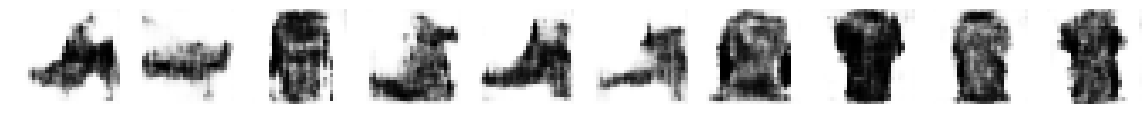

5800 	 C loss: 0.999953 	 G loss: 1.000074 	 n iter: 5


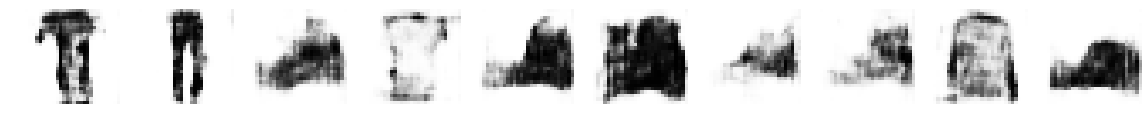

5900 	 C loss: 0.999948 	 G loss: 1.000072 	 n iter: 5


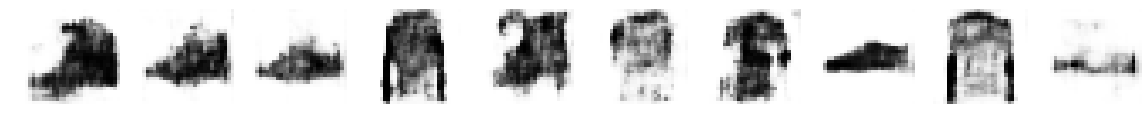

6000 	 C loss: 0.999952 	 G loss: 1.000070 	 n iter: 100


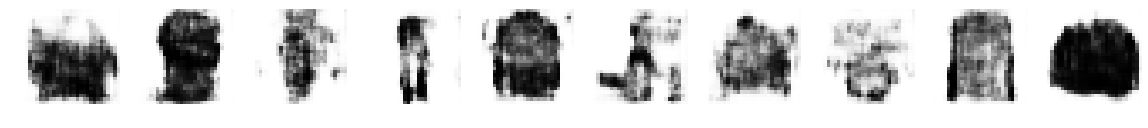

6100 	 C loss: 0.999954 	 G loss: 1.000070 	 n iter: 5


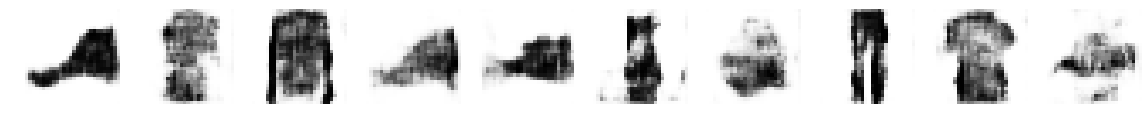

6200 	 C loss: 0.999955 	 G loss: 1.000073 	 n iter: 5


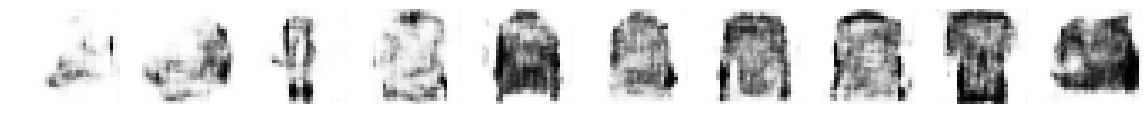

6300 	 C loss: 0.999953 	 G loss: 1.000068 	 n iter: 5


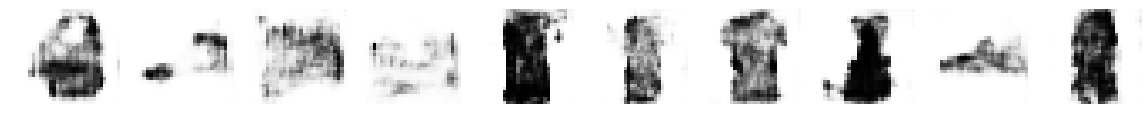

6400 	 C loss: 0.999949 	 G loss: 1.000073 	 n iter: 5


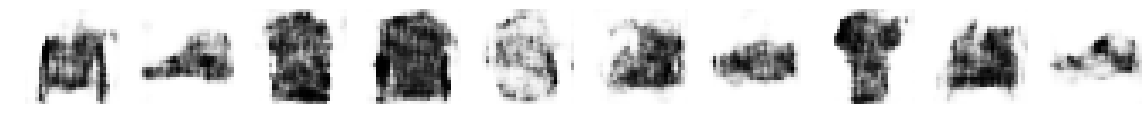

6500 	 C loss: 0.999978 	 G loss: 1.000062 	 n iter: 100


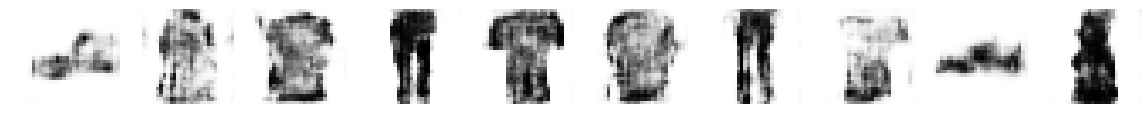

6600 	 C loss: 0.999949 	 G loss: 1.000072 	 n iter: 5


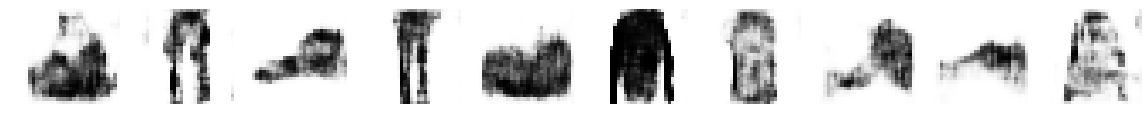

6700 	 C loss: 0.999951 	 G loss: 1.000071 	 n iter: 5


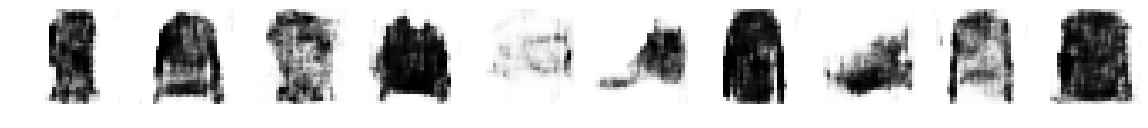

6800 	 C loss: 0.999953 	 G loss: 1.000070 	 n iter: 5


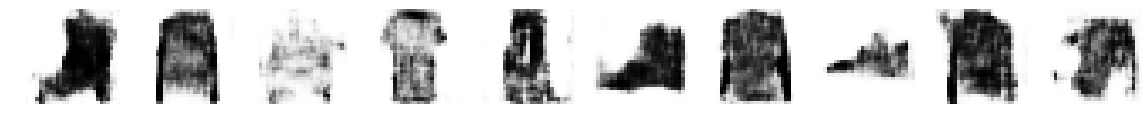

6900 	 C loss: 0.999954 	 G loss: 1.000069 	 n iter: 5


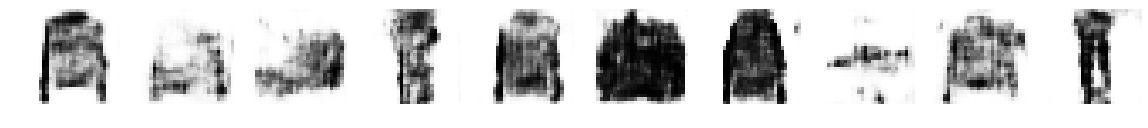

7000 	 C loss: 0.999951 	 G loss: 1.000073 	 n iter: 100


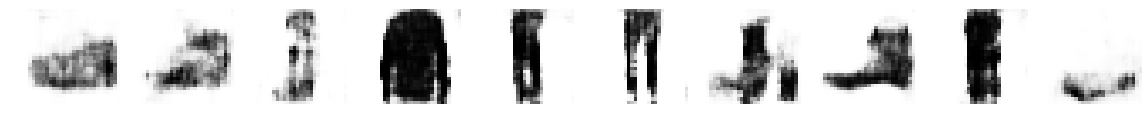

7100 	 C loss: 0.999953 	 G loss: 1.000071 	 n iter: 5


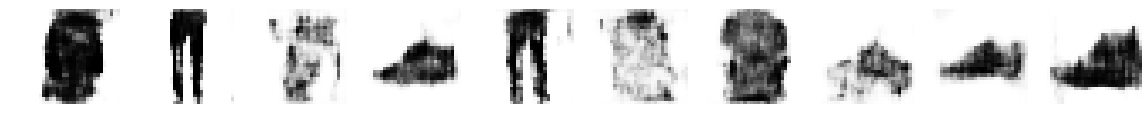

7200 	 C loss: 0.999952 	 G loss: 1.000071 	 n iter: 5


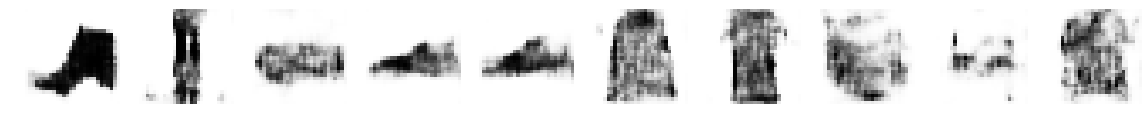

7300 	 C loss: 0.999951 	 G loss: 1.000068 	 n iter: 5


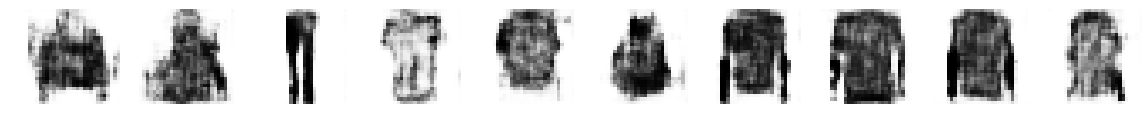

7400 	 C loss: 0.999953 	 G loss: 1.000070 	 n iter: 5


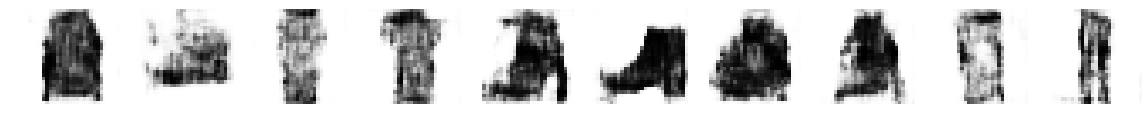

7500 	 C loss: 0.999952 	 G loss: 1.000070 	 n iter: 100


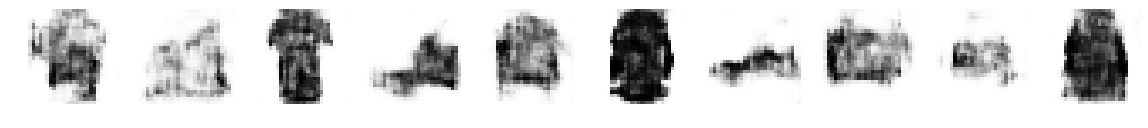

7600 	 C loss: 0.999955 	 G loss: 1.000069 	 n iter: 5


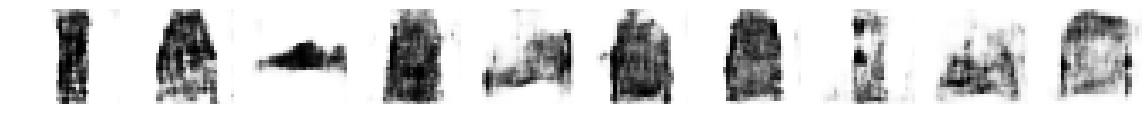

7700 	 C loss: 0.999951 	 G loss: 1.000068 	 n iter: 5


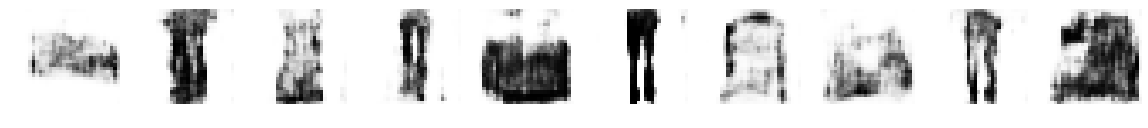

7800 	 C loss: 0.999949 	 G loss: 1.000066 	 n iter: 5


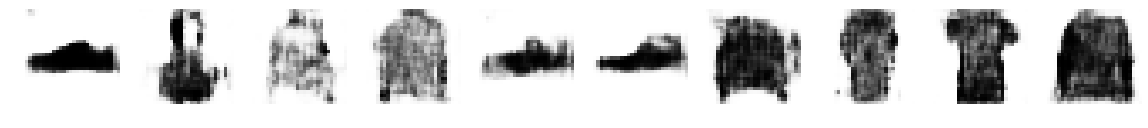

7900 	 C loss: 0.999952 	 G loss: 1.000066 	 n iter: 5


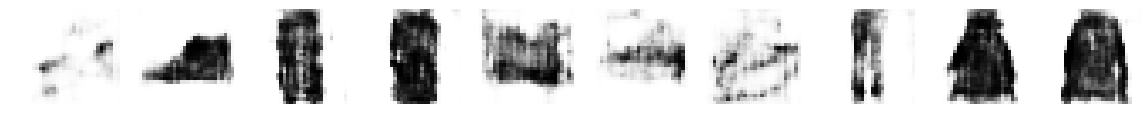

8000 	 C loss: 0.999959 	 G loss: 1.000068 	 n iter: 100


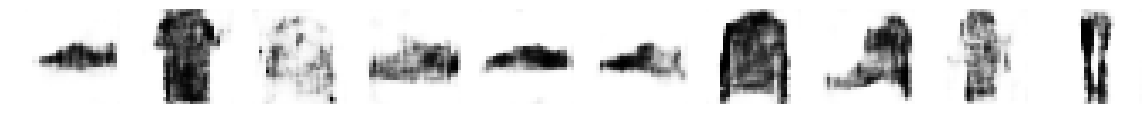

8100 	 C loss: 0.999949 	 G loss: 1.000068 	 n iter: 5


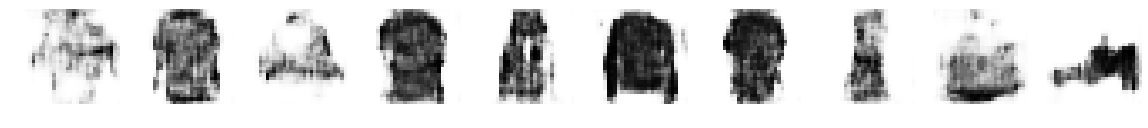

8200 	 C loss: 0.999951 	 G loss: 1.000071 	 n iter: 5


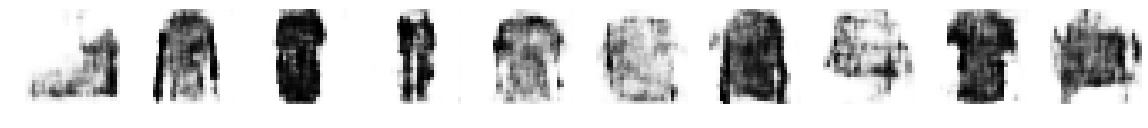

8300 	 C loss: 0.999951 	 G loss: 1.000067 	 n iter: 5


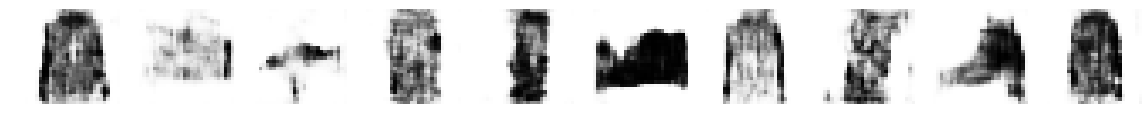

8400 	 C loss: 0.999945 	 G loss: 1.000068 	 n iter: 5


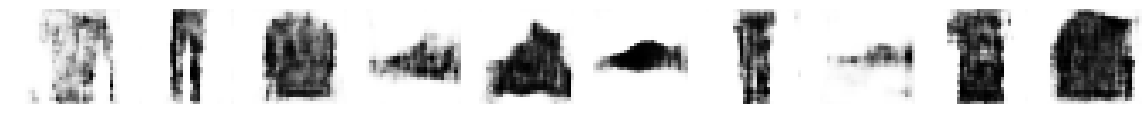

8500 	 C loss: 0.999953 	 G loss: 1.000068 	 n iter: 100


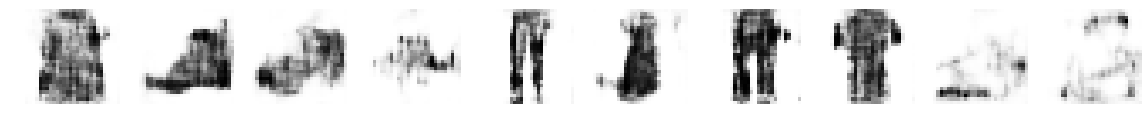

8600 	 C loss: 0.999950 	 G loss: 1.000067 	 n iter: 5


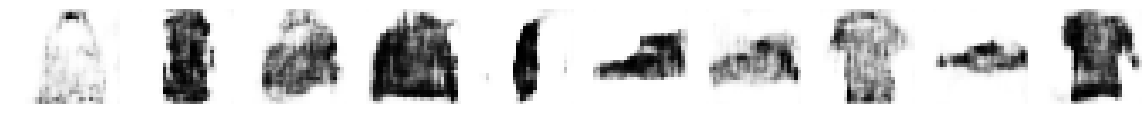

8700 	 C loss: 0.999950 	 G loss: 1.000067 	 n iter: 5


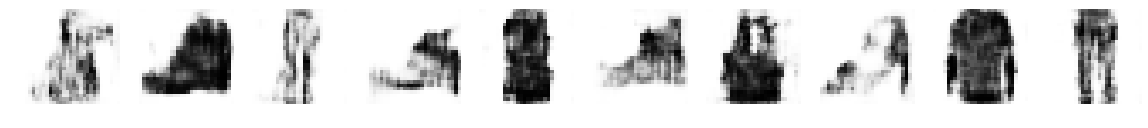

8800 	 C loss: 0.999950 	 G loss: 1.000067 	 n iter: 5


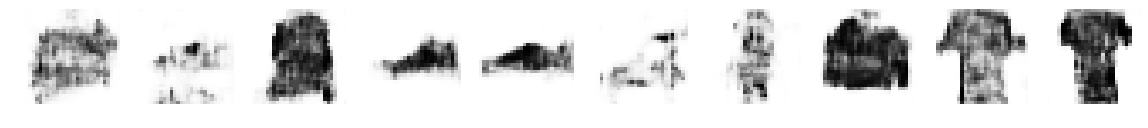

8900 	 C loss: 0.999950 	 G loss: 1.000069 	 n iter: 5


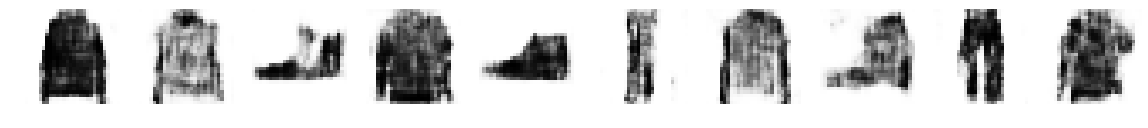

9000 	 C loss: 0.999953 	 G loss: 1.000067 	 n iter: 100


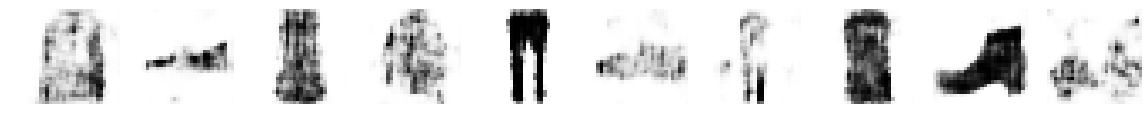

9100 	 C loss: 0.999949 	 G loss: 1.000066 	 n iter: 5


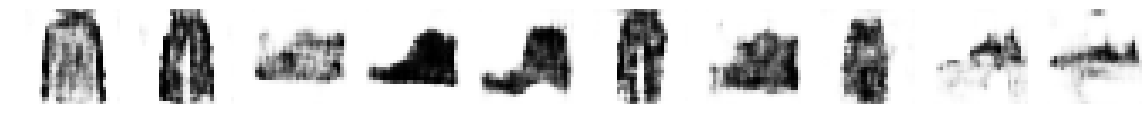

9200 	 C loss: 0.999957 	 G loss: 1.000067 	 n iter: 5


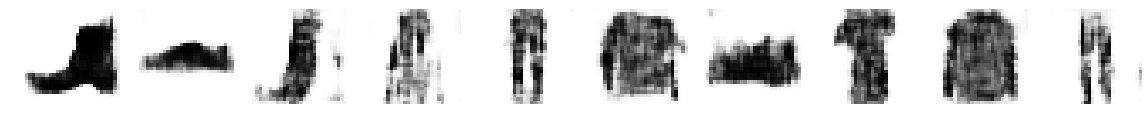

9300 	 C loss: 0.999952 	 G loss: 1.000069 	 n iter: 5


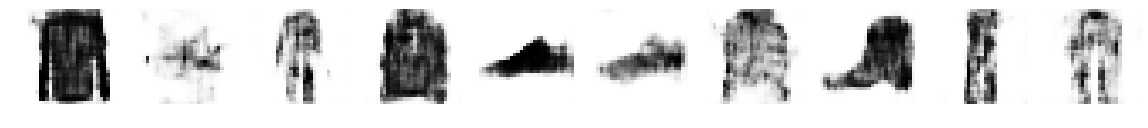

In [0]:
for r in range(rounds + 1):
  
  ## train critic
  
  for _ in range(100 if (r < 25) | (r % 500 == 0) else n_critic):
  
    # get a random batch of real examples and generate a batch of fake examples
    idx = np.random.randint(0, train_images.shape[0], batch_size)
    real_imgs = train_images[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_size))
    gen_imgs = generator.predict(noise)

    # calculate the loss for training the descriminator
    gan_c_loss_real = critic.train_on_batch(real_imgs, real_labels)
    gan_c_loss_fake = critic.train_on_batch(gen_imgs, gen_labels)
    gan_c_loss = np.add(gan_c_loss_real, gan_c_loss_fake)
    
    
    # clip the critic weights
    for l in critic.layers:
        weights = l.get_weights()
        weights = [np.clip(w, -clip_value, clip_value) for w in weights]
        l.set_weights(weights)
  
  ## train generator
  
  # generate random images and minimize the disciminators belief that these are fake
  noise = np.random.normal(0, 1, (batch_size, latent_size))

  # calculate the loss for training the generator
  gan_g_loss = combined.train_on_batch(noise, real_labels) 
  
  if r % 100 == 0:
    print ("%d \t C loss: %f \t G loss: %f \t n iter: %s" % (r, 1 - gan_c_loss, 1 - gan_g_loss, 100 if (r < 25) | (r % 500 == 0) else n_critic))
    
    noise = np.random.normal(0, 1, (10, latent_size))
    gen_imgs = generator.predict(noise)
      
    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(10):
      axs.flat[i].imshow(gen_imgs[i].squeeze())
      axs.flat[i].axis('off');
    display(fig)
    plt.close(fig)
  

## Explore the results of your GAN!

Have fun :)